## Voda Darian-Florian - NLP on YouTube Spam Collection Data Set

## Import libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Import dataset

In [2]:
df = pd.read_csv(r"C:\Users\daria\PycharmProjects\FH-Karnten-Sem2\diabetes.csv")
print(f'data shape: {df.shape}')
df.head(5)

data shape: (768, 9)


,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


## Exploratory Data Analysis (EDA)

In [3]:
df.describe()

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   insu    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 54.1+ KB


In [5]:
df.isnull().sum()

preg     0
plas     0
pres     0
skin     0
insu     0
mass     0
pedi     0
age      0
class    0
dtype: int64

There are 0 NULL values in the dataset, but we will also have to see the distribution of the data and other aspects

In [6]:
# Describe each feature grouped by class
df.groupby(['class']).describe()

preg                                                  plas  \
                 count      mean       std  min   25%  50%  75%   max  count   
class                                                                          
tested_negative  500.0  3.298000  3.017185  0.0  1.00  2.0  5.0  13.0  500.0   
tested_positive  268.0  4.865672  3.741239  0.0  1.75  4.0  8.0  17.0  268.0   

                             ...     pedi           age                        \
                       mean  ...      75%    max  count       mean        std   
class                        ...                                                
tested_negative  109.980000  ...  0.56175  2.329  500.0  31.190000  11.667655   
tested_positive  141.257463  ...  0.72800  2.420  268.0  37.067164  10.968254   

                                               
                  min   25%   50%   75%   max  
class                                          
tested_negative  21.0  23.0  27.0  37.0  81.0  
tested_positive  21.0  28.0  36.0  44.0  70.0  

[2 rows x 64 columns]

Text(0.5, 1.0, 'Distribution of class')

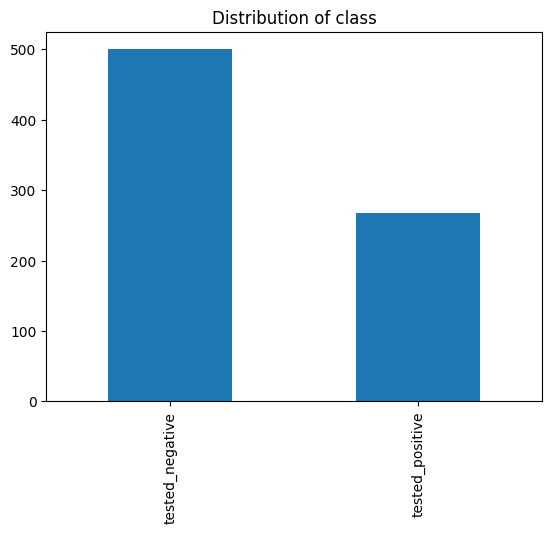

In [7]:
df['class'].value_counts().plot(kind='bar')
plt.title("Distribution of class")

Plot distribution of each feature

array([[<AxesSubplot: title={'center': 'preg'}>,
        <AxesSubplot: title={'center': 'plas'}>],
       [<AxesSubplot: title={'center': 'pres'}>,
        <AxesSubplot: title={'center': 'skin'}>],
       [<AxesSubplot: title={'center': 'insu'}>,
        <AxesSubplot: title={'center': 'mass'}>],
       [<AxesSubplot: title={'center': 'pedi'}>,
        <AxesSubplot: title={'center': 'age'}>]], dtype=object)

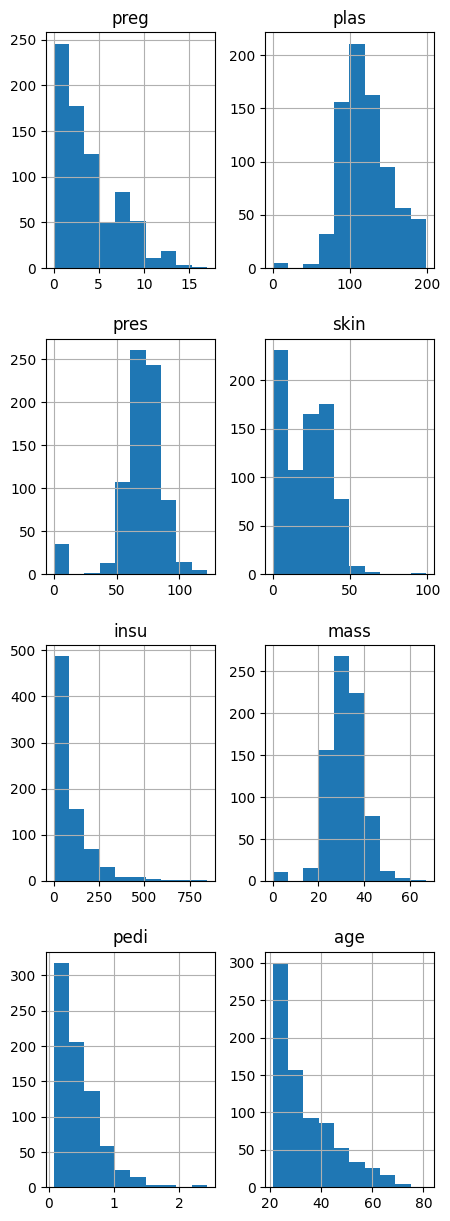

In [8]:
#define format for subplots (3 rows and 3 columns)
fig, axis = plt.subplots(4, 2, figsize=(5,15))

#create histogram for each column in DataFrame
df.hist(ax=axis)

We are trying now to see the correlation (using Person's correlation) between features

In [99]:
cormat = df.corr()
round(cormat,2)

,preg,plas,pres,skin,insu,mass,pedi,age,class
preg,1.00,0.13,0.14,-0.08,-0.07,0.02,-0.03,0.54,0.22
plas,0.13,1.00,0.15,0.06,0.33,0.22,0.14,0.26,0.47
pres,0.14,0.15,1.00,0.21,0.09,0.28,0.04,0.24,0.07
skin,-0.08,0.06,0.21,1.00,0.44,0.39,0.18,-0.11,0.07
insu,-0.07,0.33,0.09,0.44,1.00,0.20,0.19,-0.04,0.13
mass,0.02,0.22,0.28,0.39,0.20,1.00,0.14,0.04,0.29
pedi,-0.03,0.14,0.04,0.18,0.19,0.14,1.00,0.03,0.17
age,0.54,0.26,0.24,-0.11,-0.04,0.04,0.03,1.00,0.24
class,0.22,0.47,0.07,0.07,0.13,0.29,0.17,0.24,1.00


Use a heatmap to see better the correlations

<AxesSubplot: >

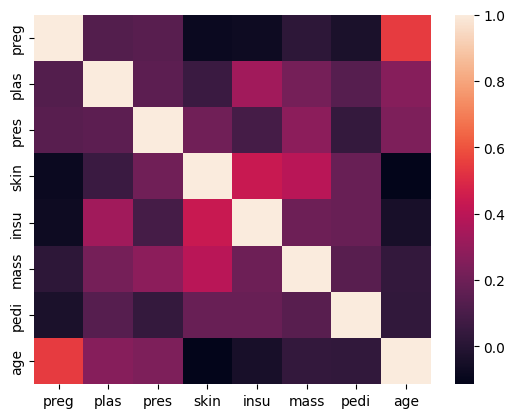

In [10]:
sns.heatmap(cormat)

After all this EDA we can conclude that:
- There are quite many 0 values for many features
- We can remove the observations with 0 values OR keep them, having there 2 cases

## Preprocess

We use a binary encoder for the class

In [12]:
oe_style_3 = {"tested_positive": 1, "tested_negative": 0}
df['class'] = df['class'].replace(oe_style_3)
df

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


We use a StandardScaler to standardize our data and select our features

In [13]:
from sklearn.preprocessing import StandardScaler

features = ['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi',
            'age']

# Separating out the features
X = df.loc[:, features].values

# Separating out the target
y = df.loc[:,['class']].values

# Standardizing the features
X = StandardScaler().fit_transform(X)
X

array([[ 0.63994726,  0.84832379,  0.14964075, ...,  0.20401277,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.12339636, -0.16054575, ..., -0.68442195,
        -0.36506078, -0.19067191],
       [ 1.23388019,  1.94372388, -0.26394125, ..., -1.10325546,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 ,  0.00330087,  0.14964075, ..., -0.73518964,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.1597866 , -0.47073225, ..., -0.24020459,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.8730192 ,  0.04624525, ..., -0.20212881,
        -0.47378505, -0.87137393]])

In [14]:
y

array([[1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
    

## Combine PCA and SVM

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principal_components
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df[['class']]], axis = 1)
pca.explained_variance_ratio_

array([0.26179749, 0.21640127])

A procent of ~47% of information was kept, but ~53% was lost, which is not so good.

In [16]:
principal_components

array([[ 1.06850273,  1.23489499],
       [-1.12168331, -0.73385167],
       [-0.39647671,  1.59587594],
       ...,
       [-0.28347525,  0.09706503],
       [-1.06032431,  0.83706234],
       [-0.83989172, -1.15175485]])

In [17]:
finalDf

,principal component 1,principal component 2,class
0,1.068503,1.234895,1
1,-1.121683,-0.733852,0
2,-0.396477,1.595876,1
3,-1.115781,-1.271241,0
4,2.359334,-2.184819,1
...,...,...,...
763,1.562085,1.923150,0
764,-0.100405,-0.614181,0
765,-0.283475,0.097065,0
766,-1.060324,0.837062,1


<Figure size 640x480 with 0 Axes>

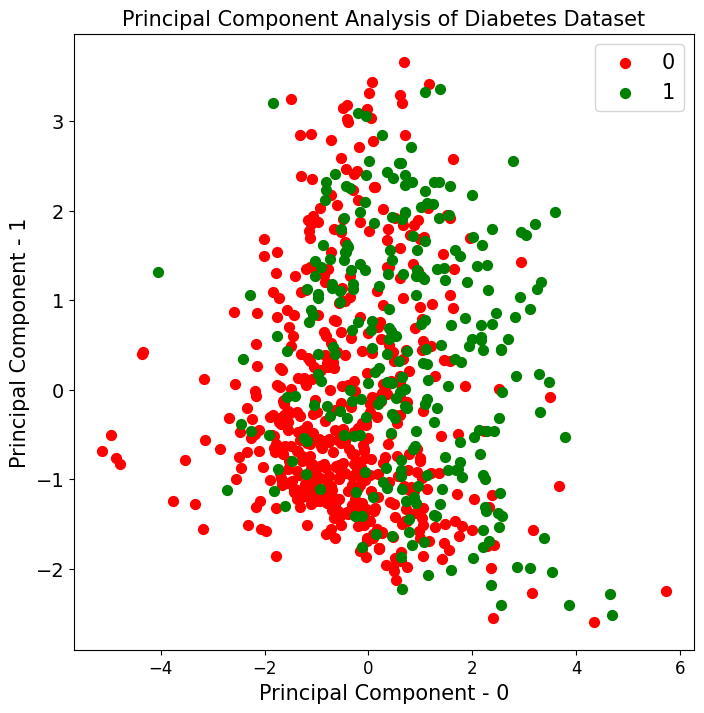

In [18]:
plt.figure()
plt.figure(figsize=(8,8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 0',fontsize=15)
plt.ylabel('Principal Component - 1',fontsize=15)
plt.title("Principal Component Analysis of Diabetes Dataset",fontsize=15)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['class'] == target
    plt.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

### Train/Test Split

In [50]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(finalDf.loc[:,["principal component 1", "principal component 2"]],
                                                    finalDf.loc[:,["class"]], test_size=0.3,random_state=109) # 70% training and 30% test

## Apply SVM with linear Kernel

In [55]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train.values.ravel())

#Predict the response for test dataset
y_pred = clf.predict(X_test)

## Evaluate model

In [56]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6926406926406926


In [57]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Precision: 0.5901639344262295
Recall: 0.43902439024390244
F1 Score: 0.5034965034965034


## Apply SVM with polynomial Kernel

In [59]:
#Create a svm Classifier
clf = svm.SVC(kernel='poly') # polynomial Kernel

#Train the model using the training sets
clf.fit(X_train, y_train.values.ravel())

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.696969696969697
Precision: 0.8333333333333334
Recall: 0.18292682926829268
F1 Score: 0.3


## Apply SVM with Radial Basis Function (RBF) Kernel

In [60]:
#Create a svm Classifier
clf = svm.SVC(kernel='rbf') # RBF Kernel

#Train the model using the training sets
clf.fit(X_train, y_train.values.ravel())

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.7186147186147186
Precision: 0.673469387755102
Recall: 0.4024390243902439
F1 Score: 0.5038167938931297


## Apply SVM with Sigmoid Kernel

In [61]:
#Create a svm Classifier
clf = svm.SVC(kernel='sigmoid') # Sigmoid Kernel

#Train the model using the training sets
clf.fit(X_train, y_train.values.ravel())

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

Accuracy: 0.6060606060606061
Precision: 0.45054945054945056
Recall: 0.5
F1 Score: 0.4739884393063584


## Overall Results after trying each Kernel

|   Kernel   | Accuracy | Precision | Recall | F1-Score |
|:----------:|:--------:|:---------:|:------:|:--------:|
|   Linear   |   0.69   |   0.59    |  0.43  |   0.50   |
| Polynomial |   0.69   |   0.83    |  0.18  |   0.30   |
|     RBF    |   0.71   |   0.67    |  0.40  |   0.50   |
|   Sigmoid  |   0.60   |   0.45    |  0.50  |   0.47   |

## Best fit parameters through exhaustive grid search cross-validation

Checking the default parameters

In [62]:
from sklearn.svm import SVC

# Check default values
svc = SVC()
params = svc.get_params()
params_df = pd.DataFrame(params, index=[0])
params_df.T

,0
C,1.0
break_ties,False
cache_size,200
class_weight,None
coef0,0.0
decision_function_shape,ovr
degree,3
gamma,scale
kernel,rbf
max_iter,-1


### Generating C and Gamma values

Source: [Medium - I'm sorry, it was the first result even though I looked up also on scikit-learn](https://medium.com/grabngoinfo/support-vector-machine-svm-hyperparameter-tuning-in-python-a65586289bcb)

In [64]:
# Run model
svc.fit(X_train, y_train.values.ravel())
# Accuracy score
print(f'The accuracy score of the model is {svc.score(X_test, y_test):.4f}')

The accuracy score of the model is 0.7186


In [65]:
import numpy as np

# List of C values
C_range = np.logspace(-1, 1, 3)
print(f'The list of values for C are {C_range}')
# List of gamma values
gamma_range = np.logspace(-1, 1, 3)
print(f'The list of values for gamma are {gamma_range}')

The list of values for C are [ 0.1  1.  10. ]
The list of values for gamma are [ 0.1  1.  10. ]


### Running Exhaustive GridSearch using 3-CV

In [72]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Define the search space
param_grid = {
    # Regularization parameter.
    "C": C_range,
    # Kernel type
    "kernel": ['linear', 'rbf', 'poly', 'sigmoid'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
    }
# Set up score
scoring = ['accuracy']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

# Define grid search
grid_search = GridSearchCV(estimator=svc,
                           param_grid=param_grid,
                           scoring=scoring,
                           refit='accuracy',
                           n_jobs=-1,
                           cv=kfold,
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train, y_train)

# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset is {grid_result.best_score_:.4f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters are {grid_result.best_params_}')
# Print the best accuracy score for the testing dataset
print(f'The accuracy score for the testing dataset is {grid_search.score(X_test, y_test):.4f}')

The best accuracy score for the training dataset is 0.7188
The best hyperparameters are {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
The accuracy score for the testing dataset is 0.6753


C:\Users\daria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Draw the decision boundary

C:\Users\daria\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


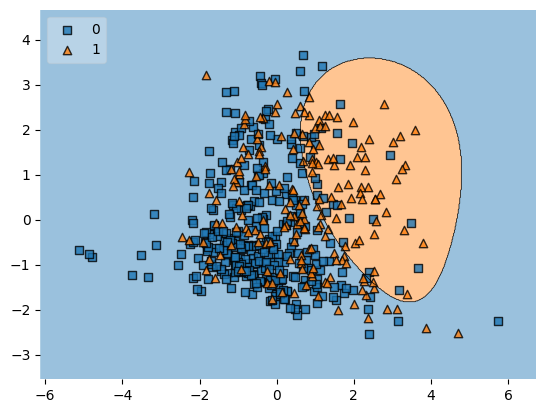

In [71]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

svm = SVC(C=0.1, kernel='rbf', gamma="scale")
svm.fit(X_train, y_train.values.ravel())
plot_decision_regions(X_train.to_numpy(), y_train.values.ravel(), clf=svm, legend=2)
plt.show()

## Conclusions on each model - diabetes.csv dataset

- Overall each model performs quite well taking into account that we train only for ~47% of information due to numerous features and reducing it with PCA up to only 2 features
- RBF kernel seems to be the best model if we refer to accuracy since the dataset is quite dense and does not have clear borders
- But since it is a medical problem, I can say that Recall is one of the most important things, since we want to know how right we were when we tried to label each patient and False Negative values are more important for diabetic people
- So, Sigmoid would be then a better kernel if we are very interested in being correct when we label a patient to be diabetic with a 0.60 score of Recall.